In [1]:
# Cell 1: Install & Mount
!pip install pandas numpy scikit-learn joblib matplotlib seaborn

from google.colab import drive
import pandas as pd
import numpy as np
import joblib

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Cell 2: Load & Preprocess
# UPDATE THIS PATH
file_path = '/content/drive/MyDrive/Titanic_project/train.csv'

try:
    df = pd.read_csv(file_path)
    print("Data Loaded Successfully.")
except FileNotFoundError:
    print("Error: File not found. Check your Google Drive path.")

# 1. Feature Selection (5 Input Features + Target)
selected_features = ['Pclass', 'Sex', 'Age', 'Fare', 'SibSp']
target = 'Survived'
data = df[selected_features + [target]].copy()

# 2. Handling Missing Values
# Fill Age with median (robust to outliers)
data['Age'].fillna(data['Age'].median(), inplace=True)
# Fill Fare with median (just in case)
data['Fare'].fillna(data['Fare'].median(), inplace=True)

# 3. Encoding Categorical Variables
# Convert 'male'/'female' to 0/1
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Sex'] = le.fit_transform(data['Sex'])
# Note: Pclass is already numeric (1, 2, 3), so we keep it as is.

print("Data Preprocessing Complete.")
print(data.head())

# Save the label encoder classes to know what is 0 and 1
print(f"Sex Encoding: {le.classes_}") # ['female' 'male'] -> 0 is female, 1 is male

Data Loaded Successfully.


/tmp/ipython-input-3596698359.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)
/tmp/ipython-input-3596698359.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

Data Preprocessing Complete.
   Pclass  Sex   Age     Fare  SibSp  Survived
0       3    1  22.0   7.2500      1         0
1       1    0  38.0  71.2833      1         1
2       3    0  26.0   7.9250      0         1
3       1    0  35.0  53.1000      1         1
4       3    1  35.0   8.0500      0         0
Sex Encoding: ['female' 'male']


In [3]:
# Cell 3: Training
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Split Data
X = data[selected_features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Random Forest (Robust & High Accuracy)
# n_estimators=100 creates 100 trees
# max_depth=10 prevents overfitting
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train
print("Training Model...")
model.fit(X_train, y_train)
print("Training Complete.")

Training Model...
Training Complete.


In [5]:
# Cell 4: Evaluation & Save
# Predict
y_pred = model.predict(X_test)

# Metrics
print("=== Model Performance ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Save Model
save_path = '/content/drive/MyDrive/Titanic_project/titanic_survival_model.pkl'
joblib.dump(model, save_path)
print(f"Model saved to: {save_path}")

# Verification: Load and test
loaded_model = joblib.load(save_path)
sample_pred = loaded_model.predict([X_test.iloc[0]])
print(f"Verification Prediction: {sample_pred[0]}")

=== Model Performance ===
Accuracy: 0.8212

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.90      0.85       105
           1       0.83      0.72      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

Model saved to: /content/drive/MyDrive/Titanic_project/titanic_survival_model.pkl
Verification Prediction: 0


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


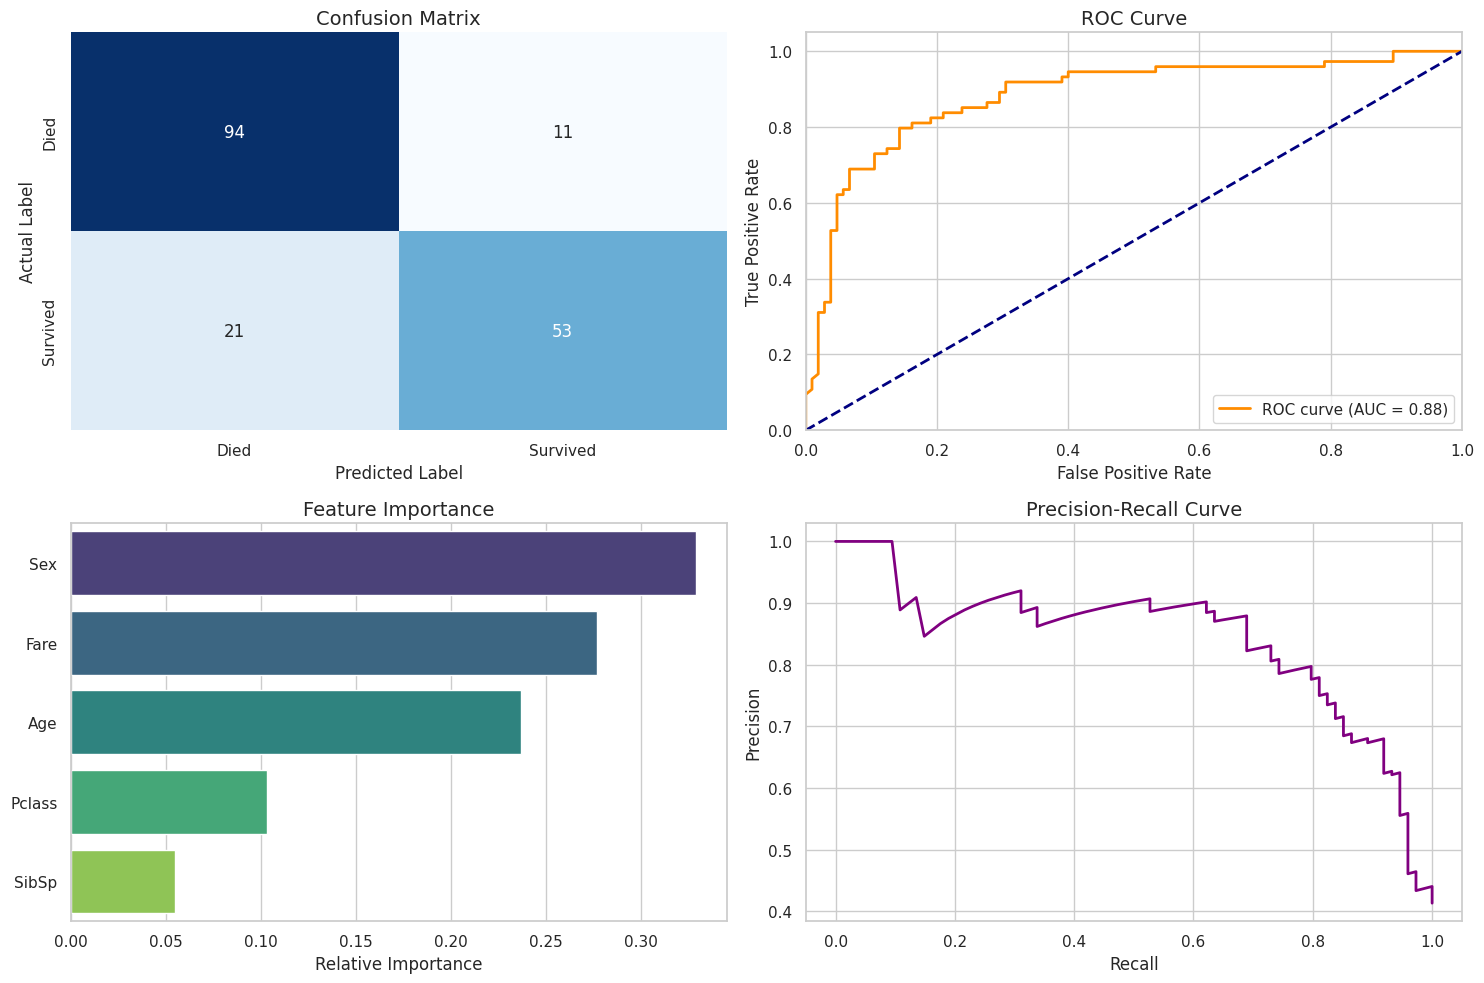

In [6]:
# Cell 5: Advanced Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Set professional style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# 1. Confusion Matrix
# Shows where the model is making mistakes (e.g., predicting dead when survived)
plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Died', 'Survived'], yticklabels=['Died', 'Survived'])
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

# 2. ROC Curve
# Shows the trade-off between True Positive Rate and False Positive Rate
# A curve closer to the top-left corner is better.
y_prob = model.predict_proba(X_test)[:, 1] # Probability of Class 1 (Survived)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.subplot(2, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontsize=14)
plt.legend(loc="lower right")

# 3. Feature Importance
# Shows which factors (Sex, Age, Class, etc.) drove the decision the most.
plt.subplot(2, 2, 3)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Use selected_features from previous cell
sns.barplot(x=importances[indices], y=np.array(selected_features)[indices], hue=np.array(selected_features)[indices], palette='viridis', legend=False)
plt.title('Feature Importance', fontsize=14)
plt.xlabel('Relative Importance')

# 4. Precision-Recall Curve
# Useful for imbalanced datasets (since more people died than survived)
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.subplot(2, 2, 4)
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', fontsize=14)

plt.tight_layout()
plt.show()